obs if you are running this in vscode, you need to select python environment as prolif, and then select the prolif environment as your kernel too 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import analysis_functions
import seaborn as sns

# Load unis using analysis scripts

In [2]:
all_unis, all_lens = analysis_functions.load_em_unis()

# Run fp , save df, put in dict

If you don't change anything here you could turn this calculation to false to save time. Right now I have skip50 on to make the calculation smoother

In [3]:
all_fp_dfs = {}
skip = 1

for condition in all_unis.keys():
    # print(condition)
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[condition]):
        if (
            condition != "PfHT_apo"
        ):  ## no need to run fingerprints on sim that doesn't have mmv...
            df = analysis_functions.get_fp_dataframe(
                u=rep_fp,
                skip=skip,
                run_calc=False,
                filename=f"{condition}.replica_{n+1}.skip{skip}",
            )
            temp_fp_dfs.append(df)
    all_fp_dfs[condition] = temp_fp_dfs
all_fp_dfs.pop("PfHT_apo")  ## probably a better way to remove this guy, but that's ok

[]

# Calculate percentage of whatever interaction you want

This was originally for pi stacking with w412 but you could do this with anything now since I realized I will need it for serine 432 and maybe others
Just find where TRP412 (or equivalent) is in the dataframe, then divide sum (since only True or False) by total sim length


save in numpy array called `all_pis` with shape (`[n_conditions], [n_replicas]`)

In [4]:
def percentage_specific_intxn_all_sims(
        PfHT_residue_number: str,
        GLUT1_residue_number: str,
        interaction_name: str,
        all_fp_dfs: dict = all_fp_dfs,
        n_conditions: int = 4,
        n_reps: int = 3
) -> np.array: 
    """
    Will read the dict of fingerprints, condition by condition, for each replica
    Find percentage of True in each df
    Will return a np array with shape (n_conditions, n_reps) (4,3) currently

    """   
    
    all_percentages = np.zeros((n_conditions, n_reps))

    for cond_index, condition in enumerate(all_fp_dfs.keys()):
        for rep_index, replica in enumerate(all_fp_dfs[condition]):
            if "GLUT1" in condition:
                try:
                    percent_True = (replica[GLUT1_residue_number][interaction_name].sum()) / len(replica)
                except KeyError:  # if there is never pi stacking, won't find it in the df
                    percent_True = 0

            else:
                try:
                    percent_True = (replica[PfHT_residue_number][interaction_name].sum()) / len(replica)
                except KeyError:  # if there is never pi stacking, won't find it in the df
                    percent_True = 0


            all_percentages[cond_index, rep_index] = percent_True
    
    return all_percentages

#### function to plot grouped barplot for this

In [5]:
def plot_grouped_barplot(
        percentage_array: np.array,
        ax: plt.axes,
        intxn_name: str,
        all_fp_dfs: dict = all_fp_dfs
) -> plt.axes:
    x = np.arange(np.shape(percentage_array)[0])
    width = 0.2
    ax.bar(x - 0.2, percentage_array[:, 0], width, color="cyan")
    ax.bar(x, percentage_array[:, 1], width, color="orange")
    ax.bar(x + 0.2, percentage_array[:, 2], width, color="red")

    ax.set_xticks(x, all_fp_dfs.keys())
    ax.set_xlabel("Condition")
    ax.set_ylabel(f"Percent {intxn_name} in sim")
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0], ['0%', '20%', '40%', '60%', '80%', '100%'])
    ax.legend(["Rep 1", "Rep 2", "Rep 3"])

##### w412 pi stacking. Just using the two functionas above

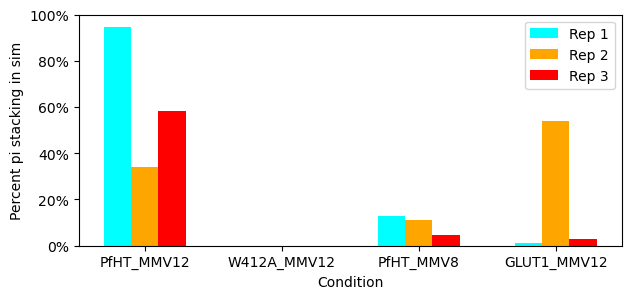

In [6]:
all_pi = percentage_specific_intxn_all_sims(
    PfHT_residue_number='TRP391',
    GLUT1_residue_number='TRP381',
    interaction_name="PiStacking"
)

f,ax = plt.subplots(1,1, figsize=(7,3))
plot_grouped_barplot(
    percentage_array=all_pi, 
                     ax=ax,
                     intxn_name='pi stacking'
                     )


#### s432 h bonding

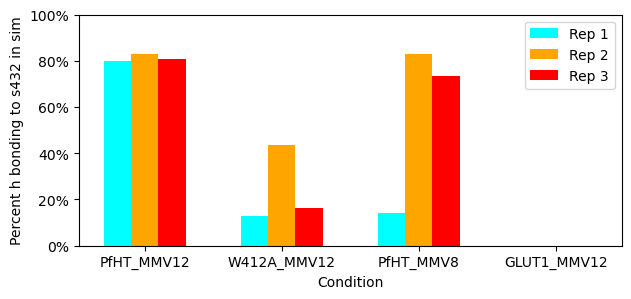

In [7]:
s432 = percentage_specific_intxn_all_sims(
    PfHT_residue_number='SER411',
    GLUT1_residue_number='SER411',
    interaction_name="HBAcceptor"
)

f,ax = plt.subplots(1,1, figsize=(7,3))
plot_grouped_barplot(
    percentage_array=s432, 
                     ax=ax,
                     intxn_name='h bonding to s432'
                     )


# sandbox again

In [157]:
# keep for now, will remove after I validate Ivens code

def get_all_mean_intxn_time_dfs_wide(
    intxn_name: str,
    mean_cutoff: float=0.1,    
    all_fp_dfs: dict=all_fp_dfs
) -> pd.DataFrame:
    """
    Calculates the mean interaction time for a specified interaction type
    Returns a multilevel dataframe with residue interacting as the index,
      and replica #(python indexed) as the column name, for each condition multi index
      this is in wide format, but we need to be able to keep Nans in place for ensuring that zeros
      are counted

      Intention is therefore to drop GLUT1 from this dataframe, and then melt along residues
      to get a long form dataframe
    """

    all_mean_interactions = {}
    for condition in all_fp_dfs.keys():
        mean_intxn_all_reps = []
        for rep in all_fp_dfs[condition]:
            intxn_group_over_time = rep.xs(intxn_name, level="interaction", axis=1)
            mean_intxn = intxn_group_over_time.mean()
            mean_intxn = mean_intxn.loc[mean_intxn>mean_cutoff]
            mean_intxn_all_reps.append(mean_intxn)
        mean_intxn_all_reps = pd.concat(mean_intxn_all_reps, axis=1, keys=[f'replica 1', 'replica 2', 'replica 3'])
        all_mean_interactions[condition] = mean_intxn_all_reps

    all_mean_interactions = pd.concat(all_mean_interactions, axis=1)
    return all_mean_interactions


In [158]:
all_mean_interactions = get_all_mean_intxn_time_dfs_wide(
    intxn_name='HBAcceptor'
)

# remove GLUT1 columns and then rows from table, no match with PfHT so no need to check
del all_mean_interactions['GLUT1_MMV12']
all_mean_interactions = all_mean_interactions.dropna(how='all',axis=0)


# melt dataframe to make long
all_mean_interactions = (all_mean_interactions.fillna(0.0)
        .reset_index()
        .rename({"protein": "residue"}, axis=1)
        .melt(id_vars=["residue"], var_name=["protein", "replica"])
)

all_mean_interactions


,residue,protein,replica,value
0,GLN148,PfHT_MMV12,replica 1,0.918082
1,SER411,PfHT_MMV12,replica 1,0.801199
2,GLN285,PfHT_MMV12,replica 1,0.000000
3,ASN290,PfHT_MMV12,replica 1,0.000000
4,HSD147,PfHT_MMV12,replica 1,0.000000
...,...,...,...,...
58,GLN285,PfHT_MMV8,replica 3,0.000000
59,ASN290,PfHT_MMV8,replica 3,0.617214
60,HSD147,PfHT_MMV8,replica 3,0.000000
61,GLY387,PfHT_MMV8,replica 3,0.000000


<Axes: xlabel='residue', ylabel='value'>

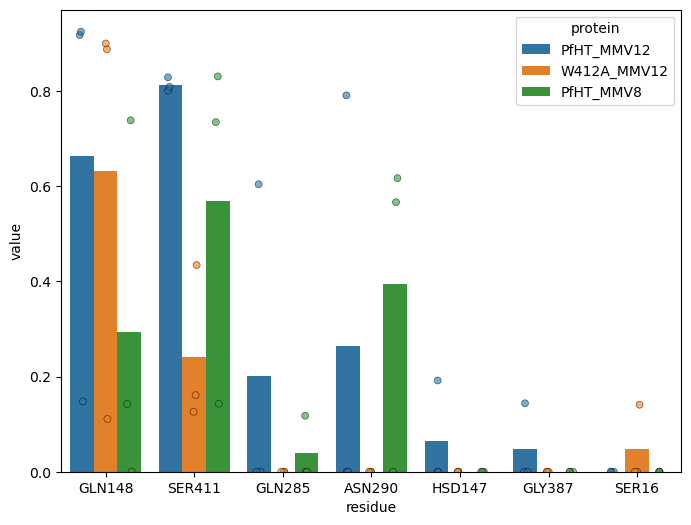

In [142]:
f,ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(data=all_mean_interactions, 
            x='residue',
            y='value',
            hue= 'protein',
            errorbar= None,
            ax= ax
            )

sns.stripplot(data=all_mean_interactions, 
            x='residue',
            y='value',
            hue= 'protein',
            ax= ax,
            dodge=True,
            alpha= 0.6,
            edgecolor='black',
            linewidth=0.5,
            legend=False
            )

In [138]:
'''
def get_all_mean_intxn_times(
        intxn_name: str, 
        mean_cutoff: float=0.1,
        all_fp_dfs: dict=all_fp_dfs
) -> pd.DataFrame:
    """
    Caculates mean interaction time for a specified interaction
    Make the dataframe into long form so we can easily read with seaborn later
    (or to change data easily)

    Will return a longform df with:
    plain number index
    columns: residue name, value (mean intxn time), protein(sim name), replica (rep #)
    """

    all_dfs = []
    for sim_name, df_list in all_fp_dfs.items():
        for rep_index, rep_fp in enumerate(df_list):
            rep_fp = rep_fp.xs(intxn_name, level="interaction", axis=1) #cross section of intxn desired
            mean_df = (
                rep_fp.mean()    
                .rename("value")
                .reset_index()
                .rename({"protein": "residue"}, axis=1)
            )
            mean_df = mean_df.loc[mean_df['value'] > mean_cutoff] # filter out means which are quite small
            mean_df["protein"] = sim_name
            mean_df["replica"] = rep_index + 1
            all_dfs.append(mean_df)

    all_dfs = pd.concat(all_dfs).reset_index(drop=True)
    return all_dfs

'''

In [75]:
test2

PfHT_MMV12                     W412A_MMV12                      \
         replica 1 replica 2 replica 3   replica 1 replica 2 replica 3   
protein                                                                  
GLN148    0.918082  0.925075  0.147852    0.900407  0.110889  0.888143   
SER411    0.801199  0.829171  0.809191    0.126016  0.434565  0.161074   
GLN285         NaN  0.604396       NaN         NaN       NaN       NaN   
ASN290         NaN  0.791209       NaN         NaN       NaN       NaN   
HSD147         NaN       NaN  0.191808         NaN       NaN       NaN   
GLY387         NaN       NaN  0.143856         NaN       NaN       NaN   
SER16          NaN       NaN       NaN         NaN  0.140859       NaN   

        PfHT_MMV8                      
        replica 1 replica 2 replica 3  
protein                                
GLN148        NaN  0.738889  0.142695  
SER411   0.143018  0.831111  0.734994  
GLN285        NaN  0.117778       NaN  
ASN290        NaN  0.566667  0.617214  
HSD147        NaN       NaN       NaN  
GLY387        NaN       NaN       NaN  
SER16         NaN       NaN       NaN

In [66]:
test2 = all_mean_interactions.fillna(0.0).reset_index().rename({"protein": "residue"}, axis=1).melt(
    id_vars=["residue"], var_name=["protein", "replica"]
)
test2

,residue,protein,replica,value
0,GLN148,PfHT_MMV12,replica 1,0.918082
1,SER411,PfHT_MMV12,replica 1,0.801199
2,GLN285,PfHT_MMV12,replica 1,0.000000
3,ASN290,PfHT_MMV12,replica 1,0.000000
4,HSD147,PfHT_MMV12,replica 1,0.000000
...,...,...,...,...
58,GLN285,PfHT_MMV8,replica 3,0.000000
59,ASN290,PfHT_MMV8,replica 3,0.617214
60,HSD147,PfHT_MMV8,replica 3,0.000000
61,GLY387,PfHT_MMV8,replica 3,0.000000
